# Analyzing the results for `finetuning_num_genes`

This is part 1, the results of sweeping all hyperparameter for rdkit

In [1]:
from pathlib import Path
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import seml
from matplotlib import pyplot as plt

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_context("poster")
pd.set_option('display.max_columns', 100)

In [4]:
results = seml.get_results(
    "check_seml",
    to_data_frame=True,
    fields=["config", "result", "seml", "config_hash"],
    states=["COMPLETED"],
    filter_dict={
        "batch_id": 1, 
        'config.dataset.data_params.split_key': 'split_ood_multi_task',
        'config.model.append_ae_layer': True,
    }
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# Look at number of experiments per model
results["config.model.embedding.model"].value_counts()

rdkit    20
Name: config.model.embedding.model, dtype: int64

In [6]:
pd.crosstab(
    results['config.model.embedding.model'],
    results['result.perturbation disentanglement'].isnull()
)

result.perturbation disentanglement,False
config.model.embedding.model,
rdkit,20


In [7]:
[c for c in results.columns if 'ae' in c]

['config.model.append_ae_layer', 'config.model.pretrained_model_hashes.jtvae']

In [8]:
pd.crosstab(
    results['config.dataset.data_params.split_key'],
    results['config.model.load_pretrained']
)

config.model.load_pretrained,False,True
config.dataset.data_params.split_key,,
split_ood_multi_task,10,10


In [9]:
pd.crosstab(
    results['config.dataset.data_params.split_key'],
    results['result.loss_reconstruction'].isnull()
)

result.loss_reconstruction,False
config.dataset.data_params.split_key,
split_ood_multi_task,20


In [10]:
# columns
results.isnull().any()[results.isnull().any()]

config.model.embedding.directory    True
dtype: bool

In [11]:
# rows without nans 
clean_id = results.loc[~results['result.training'].isnull(), '_id']
# clean_id

## Preprocessing the results dataframe

In [12]:
# percentage of training runs that resulted in NaNs or totally failed

results_clean = results[results._id.isin(clean_id)].copy()
print(f"Percentage of invalid (nan) runs: {1 - len(clean_id) / len(results)}")

# Remove runs with r2 < 0.6 on the training set
# results_clean = results_clean[results_clean['result.training'].apply(lambda x: x[0][0])>0.6]

Percentage of invalid (nan) runs: 0.0


In [13]:
results_clean["config.model.embedding.model"].value_counts()

rdkit    20
Name: config.model.embedding.model, dtype: int64

In [15]:
results_clean[['config.model.load_pretrained', 'config.model.append_ae_layer', "result.ood"]]

,config.model.load_pretrained,config.model.append_ae_layer,result.ood
0,True,True,"[[0.7792000180041349, 0.5800741546683841, 0.72..."
1,True,True,"[[0.6915165859240072, 0.5088788706947256, 0.65..."
2,True,True,"[[0.7206487655639648, 0.5369929400859056, 0.65..."
3,True,True,"[[0.7705045971605513, 0.5684001661009259, 0.67..."
4,True,True,"[[0.7636636390730187, 0.5690779912251013, 0.71..."
5,True,True,"[[0.7638630999459161, 0.5847244290290056, 0.72..."
6,True,True,"[[0.7274915708435906, 0.5385897667319687, 0.71..."
7,True,True,"[[0.7429627825816473, 0.5403365288619641, 0.68..."
8,True,True,"[[0.7641602335152803, 0.5916232433584001, 0.68..."
9,True,True,"[[0.7101644702531673, 0.5111353800252632, 0.63..."


In [16]:
# calculate some stats
get_mean = lambda x: np.array(x)[-1, 0]
get_mean_de = lambda x: np.array(x)[-1, 1]

results_clean["result.training_mean"] = results_clean["result.training"].apply(get_mean)
results_clean["result.training_mean_de"] = results_clean["result.training"].apply(get_mean_de)
results_clean["result.val_mean"] = results_clean["result.test"].apply(get_mean)
results_clean["result.val_mean_de"] = results_clean["result.test"].apply(get_mean_de)
results_clean["result.test_mean"] = results_clean["result.ood"].apply(get_mean)
results_clean["result.test_mean_de"] = results_clean["result.ood"].apply(get_mean_de)
results_clean["result.perturbation disentanglement"] = results_clean["result.perturbation disentanglement"].apply(lambda x: x[0])
results_clean["result.covariate disentanglement"] = results_clean["result.covariate disentanglement"].apply(lambda x: x[0][0])
results_clean["result.final_reconstruction"] = results_clean["result.loss_reconstruction"].apply(lambda x: x[-1])

results_clean.head(3)

,_id,config_hash,seml.executable,seml.name,seml.output_dir,seml.conda_environment,seml.working_dir,seml.source_files,seml.output_file,seml.command,seml.temp_dir,config.overwrite,config.db_collection,config.dataset.data_params.covariate_keys,config.dataset.data_params.dataset_path,config.dataset.data_params.degs_key,config.dataset.data_params.dose_key,config.dataset.data_params.pert_category,config.dataset.data_params.perturbation_key,config.dataset.data_params.smiles_key,config.dataset.data_params.split_key,config.dataset.data_params.use_drugs_idx,config.dataset.dataset_type,config.model.additional_params.decoder_activation,config.model.additional_params.doser_type,config.model.additional_params.patience,config.model.additional_params.seed,config.model.append_ae_layer,config.model.embedding.directory,config.model.embedding.model,config.model.enable_cpa_mode,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_steps,config.model.hparams.adversary_wd,config.model.hparams.adversary_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.autoencoder_width,config.model.hparams.batch_size,config.model.hparams.dim,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.dosers_width,config.model.hparams.dropout,config.model.hparams.embedding_encoder_depth,config.model.hparams.embedding_encoder_width,config.model.hparams.penalty_adversary,config.model.hparams.reg_adversary,config.model.hparams.reg_adversary_cov,config.model.hparams.reg_multi_task,config.model.hparams.step_size_lr,config.model.load_pretrained,config.model.pretrained_model_hashes.grover_base,config.model.pretrained_model_hashes.jtvae,config.model.pretrained_model_hashes.rdkit,config.model.pretrained_model_path,config.profiling.outdir,config.profiling.run_profiler,config.training.checkpoint_freq,config.training.full_eval_during_train,config.training.max_minutes,config.training.num_epochs,config.training.run_eval_disentangle,config.training.run_eval_logfold,config.training.run_eval_r2,config.training.run_eval_r2_sc,config.training.save_checkpoints,config.training.save_dir,config.seed,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.loss_multi_task,result.elapsed_time_min,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.training,result.test,result.ood,result.total_epochs,result.training_mean,result.training_mean_de,result.val_mean,result.val_mean_de,result.test_mean,result.test_mean_de,result.final_reconstruction
0,1,cbb06a358d55ba11cd1e791cc3df80ba,chemCPA/experiments_run.py,ft_dominik,/nfs/staff-hdd/hetzell/project_chemCPA/logs,chemical_CPA,/nfs/staff-ssd/hetzell/code/chemCPA,"[[chemCPA/experiments_run.py, 6674b604df37c6cb...",/nfs/staff-hdd/hetzell/project_chemCPA/logs/ft...,python chemCPA/experiments_run.py with 'model=...,/tmp/eef60f43-d107-4fa4-978d-b802844d80d5,1,check_seml,cell_type,project_folder/datasets/sciplex_complete_middl...,all_DEGs,dose,cov_drug_dose_name,condition,SMILES,split_ood_multi_task,True,trapnell,ReLU,amortized,50,1337,True,None,rdkit,False,3,0.000364,3,7.459343e-07,128,4,0.000561,1.329292e-07,256,128,32,3,0.000561,1.329292e-07,64,0.262378,4,128,0.199070,3.981399,8.605035,0,50,True,ff420aea264fca7668ecb147f60762a1,a7060ac4e2c6154e64a13acd414cbba2,4f061dbfc7af05cf84f06a724b0c8563,/nfs/homedirs/hetzell/hdd/project_chemCPA/chec...,./,False,50,False,1200,201,True,False,True,False,True,/nfs/homedirs/hetzell/hdd/project_chemCPA/chec...,803478497,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[200],"[-2752.98758001253, -4474.551327010617, -5058....","[12604.405653476715, 12552.962059497833, 12541...","[2466.0610390901566, 2469.8611637949944, 2502....","[

In [18]:
# results_clean["result.training_sc_mean"] = results_clean["result.training_sc"].apply(get_mean)
# results_clean["result.training_sc_mean_de"] = results_clean["result.training_sc"].apply(get_mean_de)
# results_clean["result.val_sc_mean"] = results_clean["result.test_sc"].apply(get_mean)
# results_clean["result.val_sc_mean_de"] = results_clean["result.test_sc"].apply(get_mean_de)
# results_clean["result.test_sc_mean"] = results_clean["result.ood_sc"].apply(get_mean)
# results_clean["result.test_sc_mean_de"] = results_clean["result.ood_sc"].apply(get_mean_de)

# results_clean = results_clean[results_clean["result.val_sc_mean"] > 0.01]
# results_clean = results_clean[results_clean["result.val_mean_de"] > 0.4]
# # results_clean = results_clean[results_clean["config.model.append_ae_layer"] == True]

## Look at early stopping

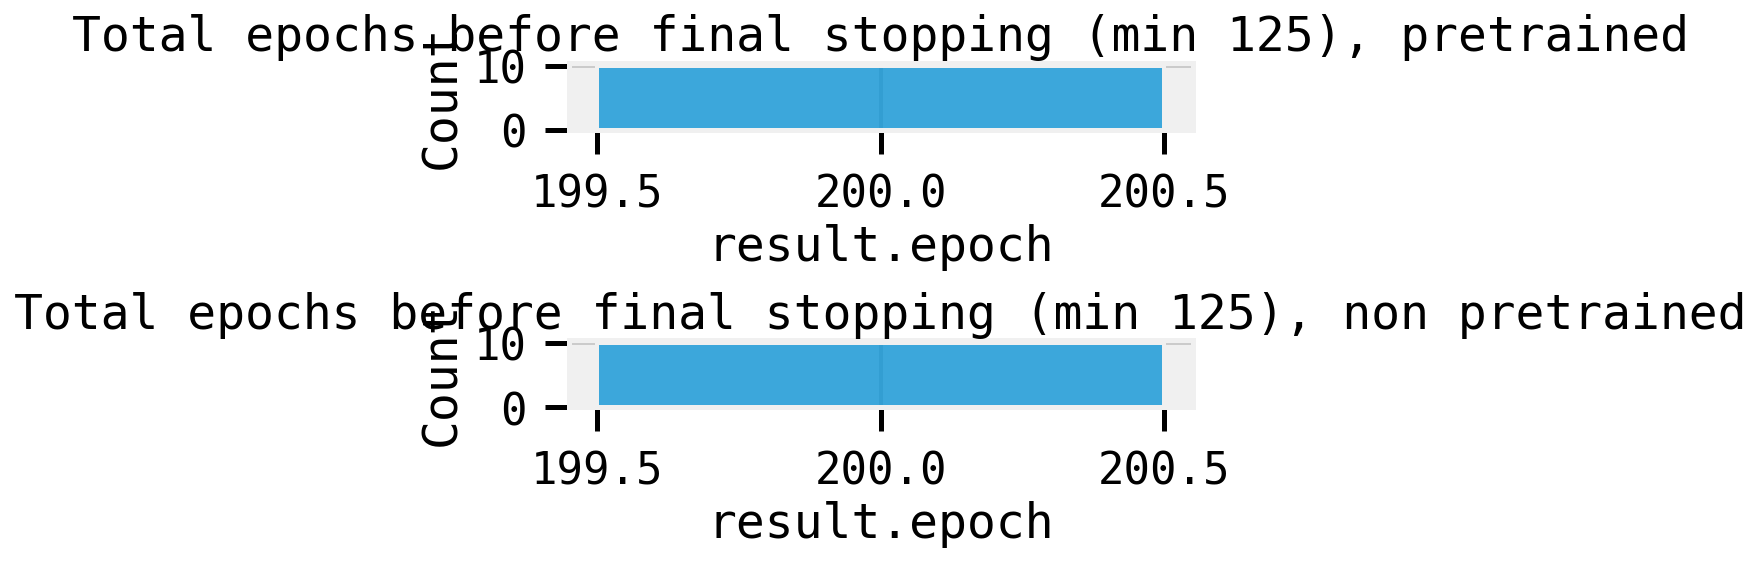

In [19]:
fig, ax = plt.subplots(2,1)
sns.histplot(data=results_clean[results_clean['config.model.load_pretrained']==True]["result.epoch"].apply(max), ax=ax[0])
ax[0].set_title("Total epochs before final stopping (min 125), pretrained")

ax[1] = sns.histplot(data=results_clean[results_clean['config.model.load_pretrained']==False]["result.epoch"].apply(max), ax=ax[1])
ax[1].set_title("Total epochs before final stopping (min 125), non pretrained")

plt.tight_layout()

## Look at $r^2$ reconstruction

In [20]:
[c for c in results_clean.columns if 'pretrain' in c]

results_clean[["config.model.embedding.model", 'config.model.load_pretrained', 'config.model.append_ae_layer']]

,config.model.embedding.model,config.model.load_pretrained,config.model.append_ae_layer
0,rdkit,True,True
1,rdkit,True,True
2,rdkit,True,True
3,rdkit,True,True
4,rdkit,True,True
5,rdkit,True,True
6,rdkit,True,True
7,rdkit,True,True
8,rdkit,True,True
9,rdkit,True,True


### DE genes

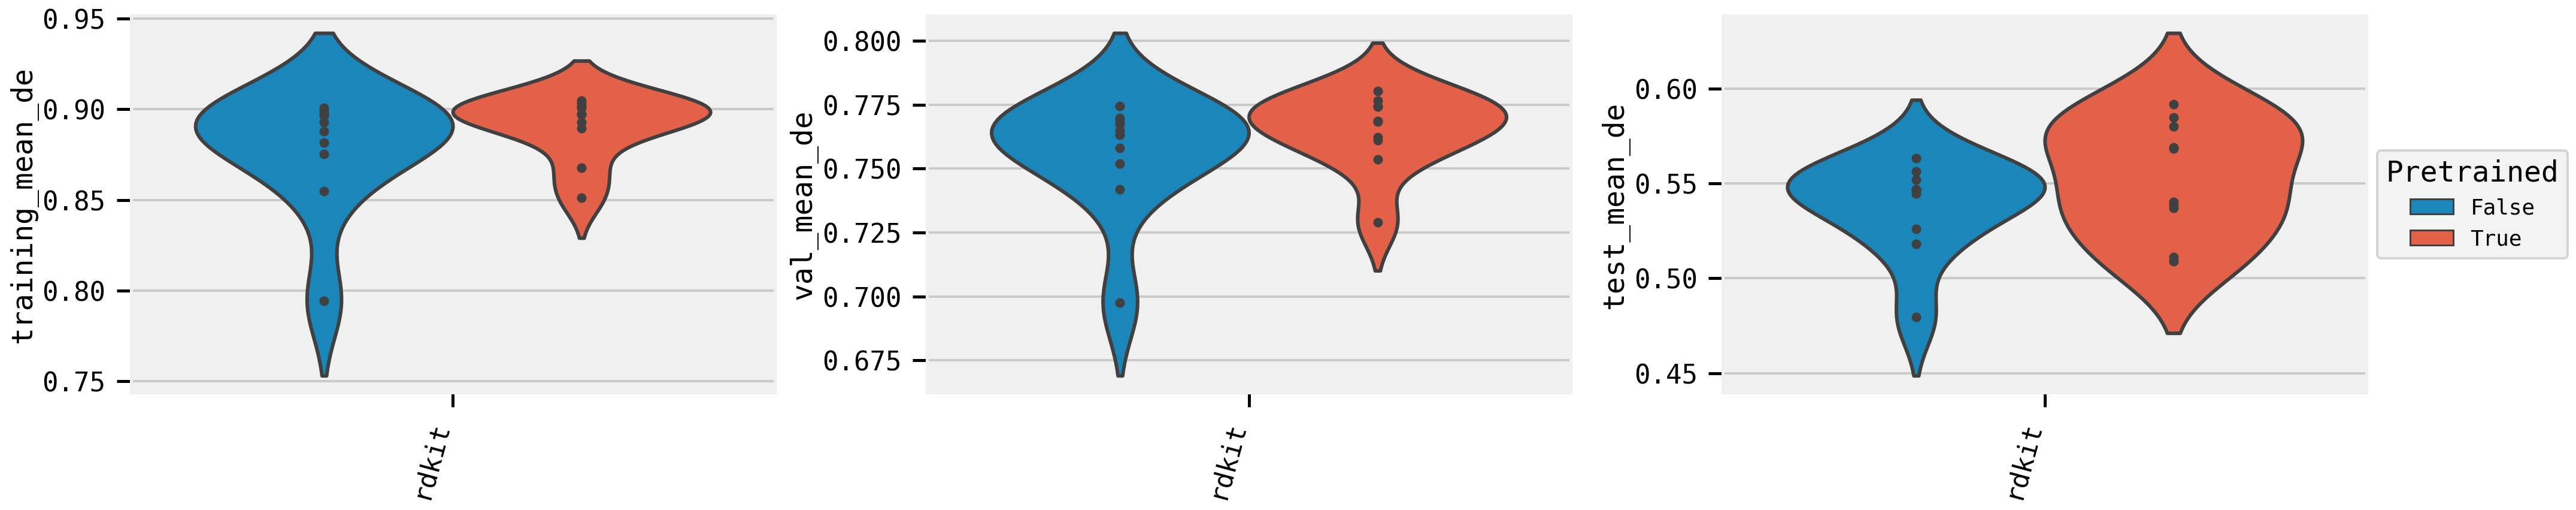

In [21]:
# DE genes
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(("result.training_mean_de", "result.val_mean_de", "result.test_mean_de")):
    sns.violinplot(
        data=results_clean, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    # ax[i].set_ylim([0.3,1.01])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [23]:
# # DE genes
# rows, cols = 1, 3
# fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

# for i, y in enumerate(("result.training_sc_mean_de", "result.val_sc_mean_de", "result.test_sc_mean_de")):
#     sns.violinplot(
#         data=results_clean, 
#         x="config.model.embedding.model", 
#         y=y, 
#         hue='config.model.load_pretrained', 
#         inner='points', 
#         ax=ax[i], 
#         scale='width',
#         )
#     ax[i].set_ylim([0.0,0.5])
#     ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
#     ax[i].set_xlabel('')
#     ax[i].set_ylabel(y.split('.')[-1])
#     ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

# ax[0].get_legend().remove()
# ax[1].get_legend().remove()
# ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
# plt.tight_layout()

### All genes

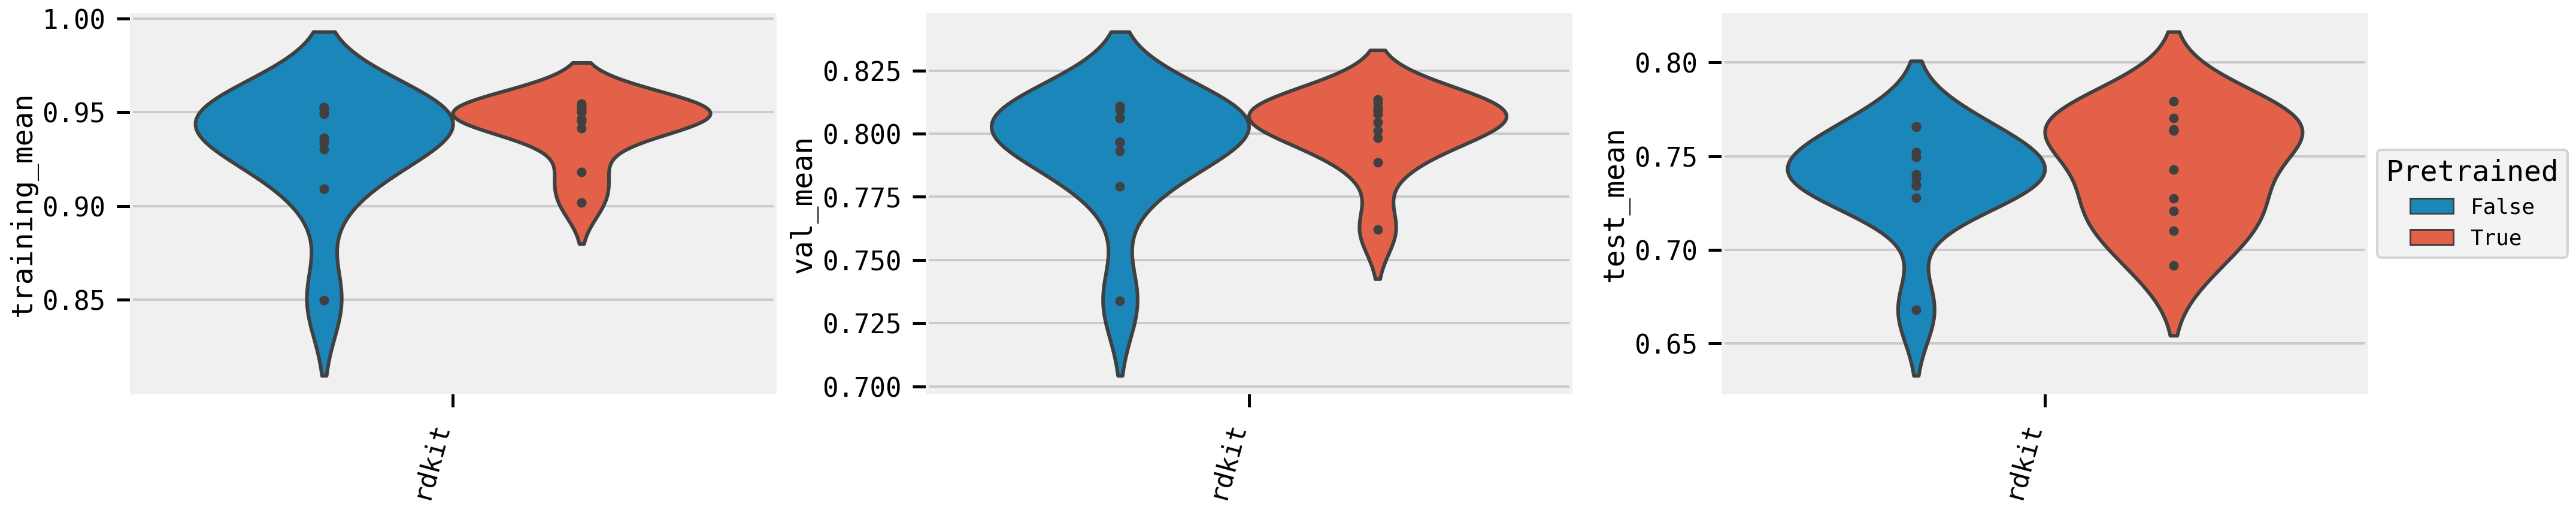

In [24]:
# DE genes
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(("result.training_mean", "result.val_mean", "result.test_mean")):
    sns.violinplot(
        data=results_clean, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    # ax[i].set_ylim([0.3,1.01])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Look at disentanglement scores

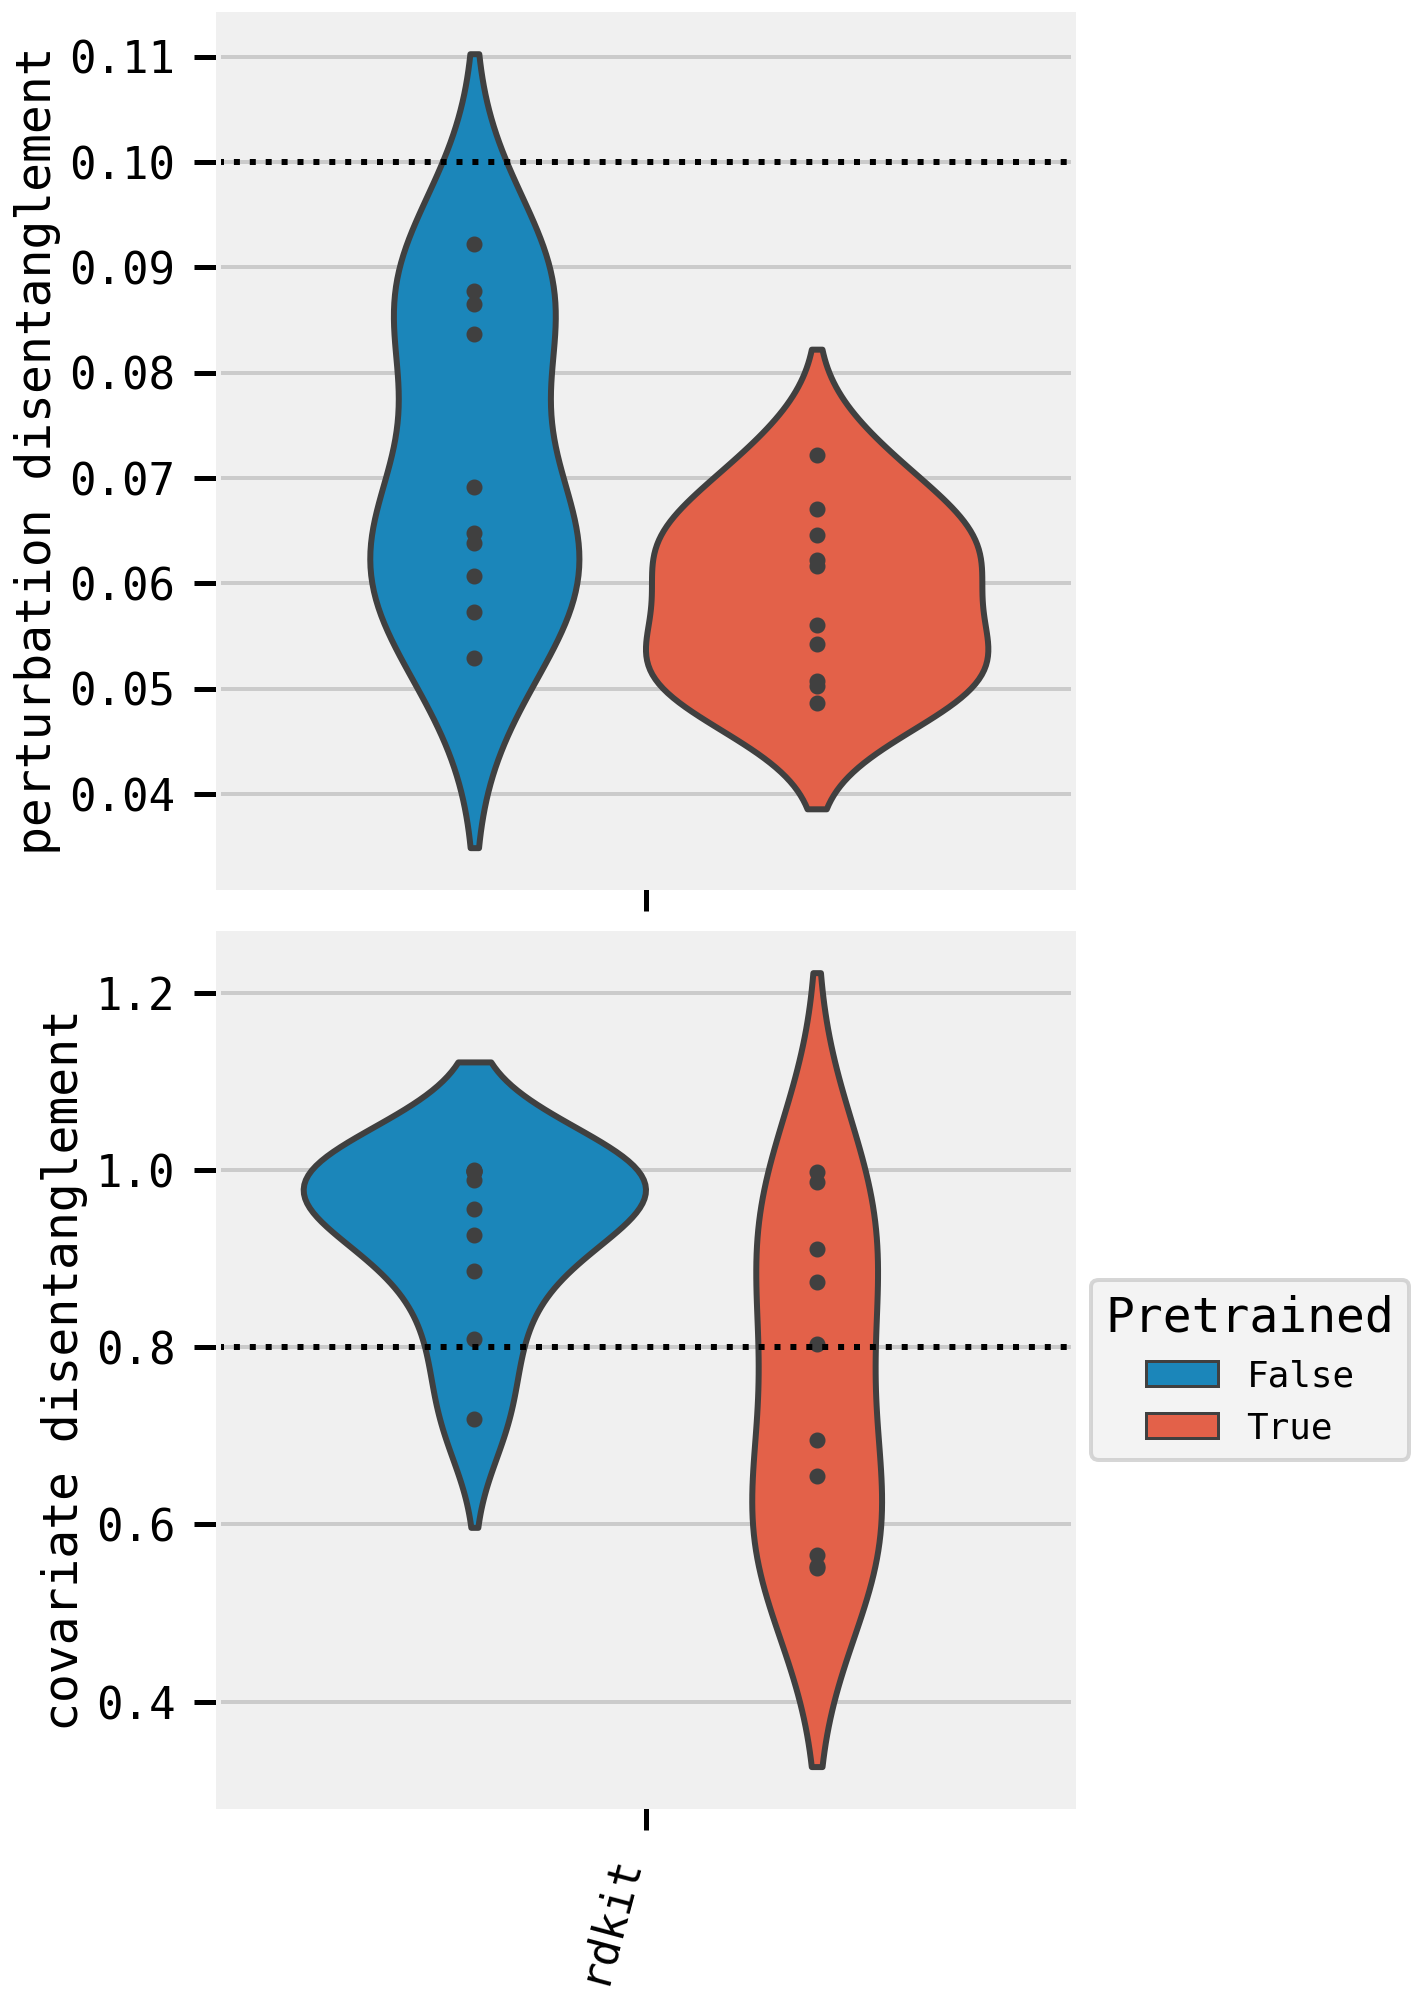

In [25]:
rows = 2 
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 7*rows), sharex=True)

max_entangle = [0.1, 0.8]
for i, y in enumerate(["result.perturbation disentanglement", "result.covariate disentanglement"]):
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i], hue="config.model.load_pretrained")
    # ax[i].set_ylim([0,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].axhline(max_entangle[i],ls=':', color='black')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
ax[0].get_legend().remove()
ax[1].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Subselect to disentangled models

In [26]:
n_top = 2
def performance_condition(emb, pretrained, max_entangle, max_entangle_cov): 
    cond = results_clean["config.model.embedding.model"] == emb
    cond = cond & (results_clean["result.perturbation disentanglement"] < max_entangle) 
    cond = cond & (results_clean["result.covariate disentanglement"] < max_entangle_cov) 
    cond = cond & (results_clean["config.model.load_pretrained"] == pretrained)
    return cond

best = []
for embedding in list(results_clean["config.model.embedding.model"].unique()):
    for pretrained in [True, False]:
        df = results_clean[performance_condition(embedding, pretrained, 1, 1)]
        print(embedding, pretrained, len(df))
        best.append(df.sort_values(by="result.val_mean_de", ascending=False).head(n_top))

best = pd.concat(best)

rdkit True 10
rdkit False 9


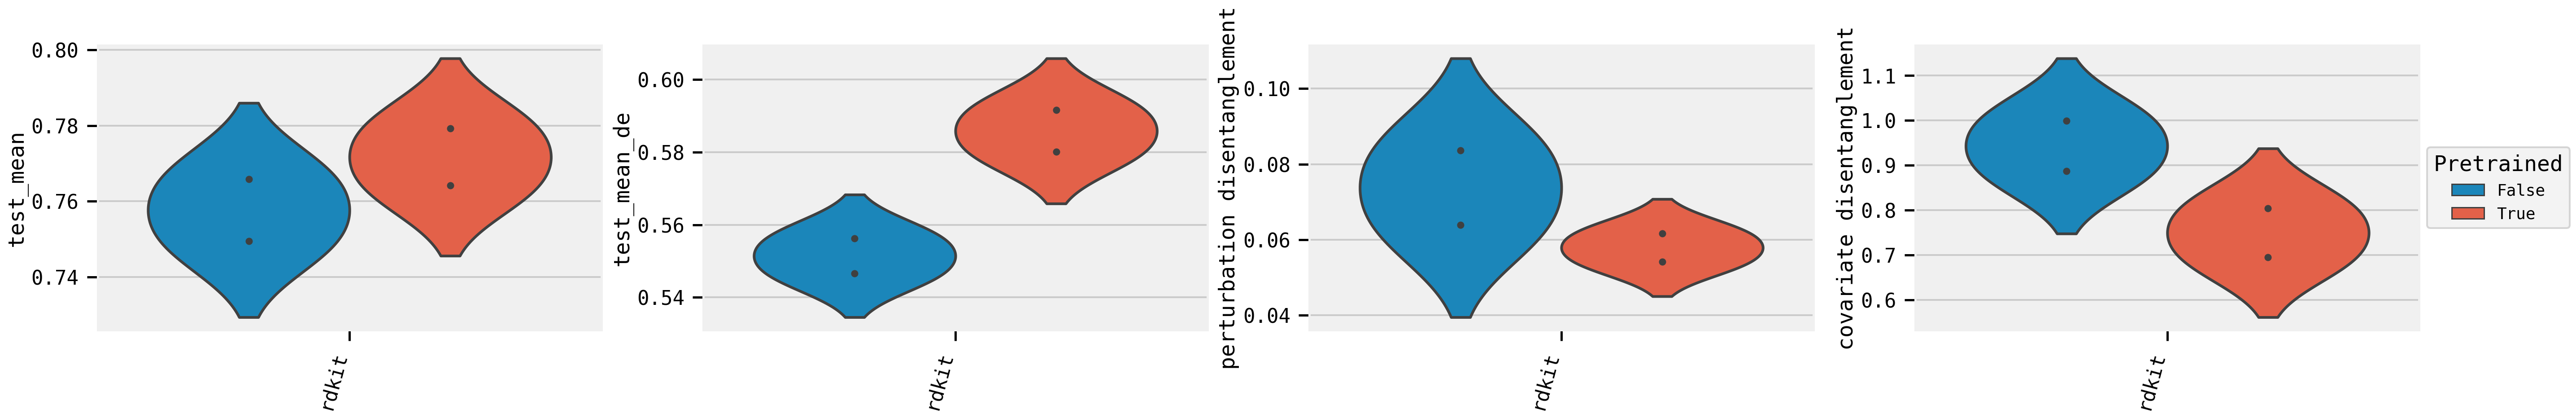

In [27]:
# All genes, DE genes, disentanglement
rows, cols = 1, 4
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.test_mean", "result.test_mean_de", "result.perturbation disentanglement", "result.covariate disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    ax[i].legend(title='Pretrained',loc='lower right', fontsize=18, title_fontsize=24)
ax[0].get_legend().remove()
# ax[0].set_ylim([0.4, 1.01])
ax[1].get_legend().remove()
# ax[1].set_ylim([0.4, 1.01])
ax[2].get_legend().remove()
ax[3].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()


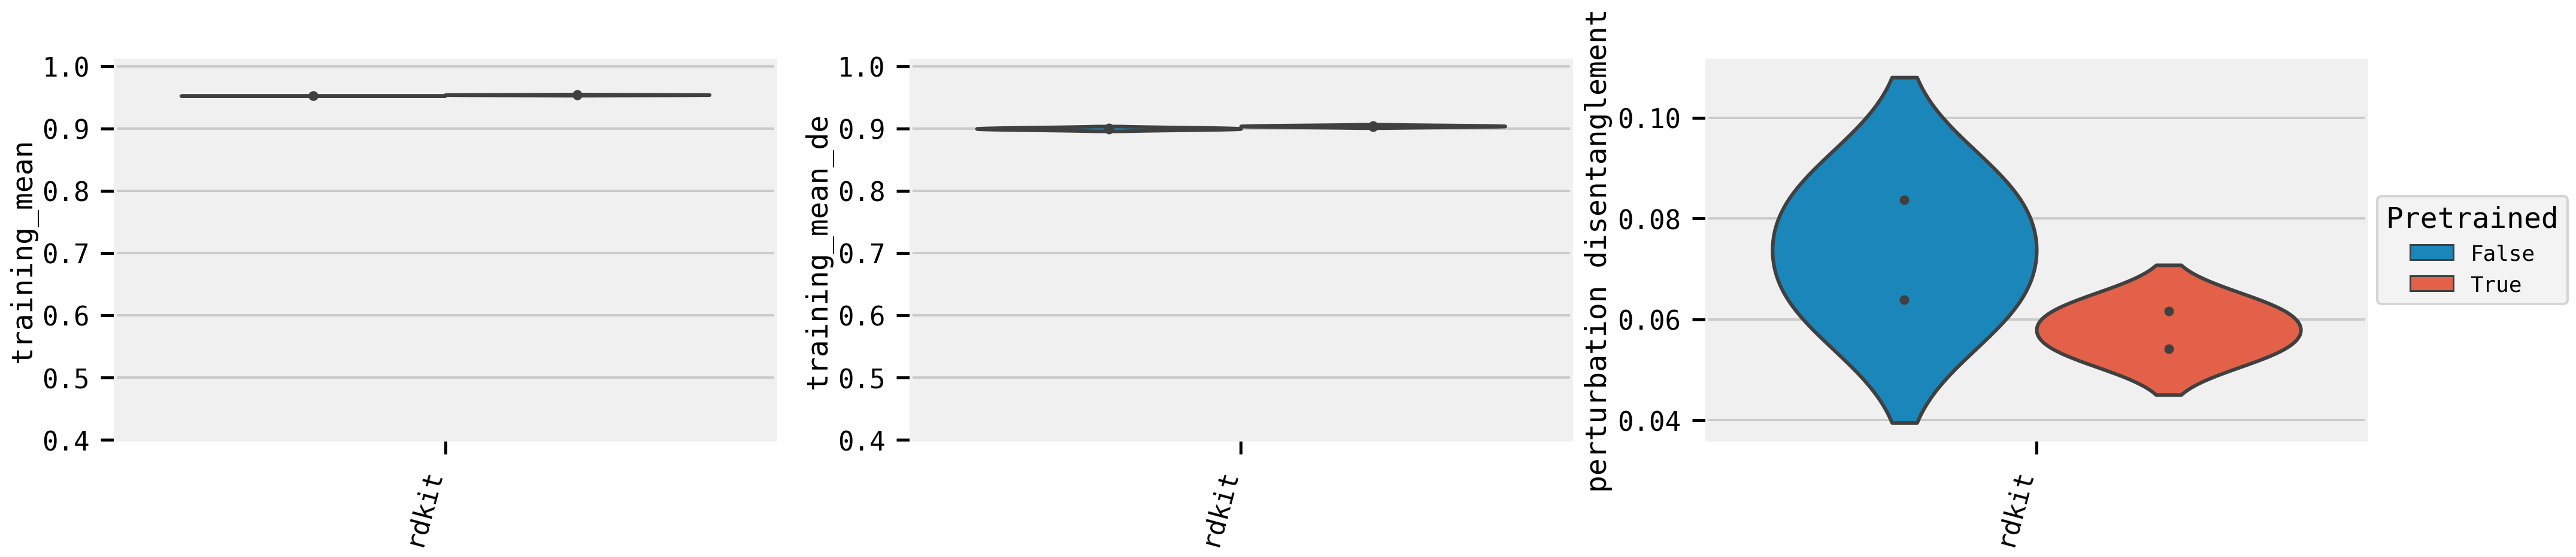

In [28]:
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,6*rows))

for i, y in enumerate(["result.training_mean", "result.training_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(
        data=best, 
        x="config.model.embedding.model", 
        y=y, 
        hue='config.model.load_pretrained', 
        inner='points', 
        ax=ax[i], 
        scale='width',
        )
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=75, ha='right')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
ax[0].get_legend().remove()
ax[0].set_ylim([0.4, 1.01])
ax[1].get_legend().remove()
ax[1].set_ylim([0.4, 1.01])
ax[2].legend(title='Pretrained', fontsize=18, title_fontsize=24, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Take a deeper look in the `.config` of the best performing models

In [29]:
[c for c in best.columns if 'hash' in c]

['config_hash',
 'config.model.pretrained_model_hashes.grover_base',
 'config.model.pretrained_model_hashes.jtvae',
 'config.model.pretrained_model_hashes.rdkit']

In [30]:
best[['config.model.load_pretrained', 'config_hash', 'result.test_mean_de', 'result.covariate disentanglement']]

,config.model.load_pretrained,config_hash,result.test_mean_de,result.covariate disentanglement
0,True,cbb06a358d55ba11cd1e791cc3df80ba,0.580074,0.803631
8,True,df620799d929c39478b7c6bf93ef74ef,0.591623,0.695012
18,False,09be7dd3cc760e25a9c95035ef7aaaff,0.556312,0.886495
10,False,ce65bf47ea39aa967b5c631cf8c521e2,0.546559,0.999287
